In [1]:
import numpy as np
import pandas as pd
from indigo import *
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# output_notebook()

### Some global variables used throughout this notebook

In [3]:
PATH = "Adrenergic_dataset.csv"
FOLDS = 5
SEED = 12
ASSAY =  "AdrA1A_PCHEMBL_VALUE"

columns = ["Structure", "ID", ASSAY]

### Read data from csv

In [4]:
df = pd.read_csv(PATH)
df.head()

,Structure,ID,logP,Vx,MW,NegativeCharge,PositiveCharge,Flex,AromaticRings,OverallCharge,...,q485,frg-8,frg-26,frg-54,Nn,AdrA1A_PCHEMBL_VALUE,AdrA1B_PCHEMBL_VALUE,AdrA1D_PCHEMBL_VALUE,AdrA2A_PCHEMBL_VALUE,AdrA2C_PCHEMBL_VALUE
0,CC\C(=C(\CC)/c1ccc(O)cc1)\c2ccc(O)cc2,CHEMBL411,4.871,224.4,268.4,0,0,0.1905,2,0,...,4,2,0,0,0,NaN,NaN,NaN,NaN,5.66
1,CSc1ccc2Sc3ccccc3N(CCC4CCCCN4C)c2c1,CHEMBL479,5.900,290.2,370.6,0,2,0.1429,2,2,...,18,0,0,0,2,NaN,NaN,NaN,NaN,7.60
2,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1,CHEMBL2205811,3.040,225.5,309.4,0,1,0.1379,1,1,...,4,0,0,0,1,NaN,NaN,NaN,NaN,6.25
3,COc1cc(CN[C@H]2C3C4CC5C6C4CC3C6C25)cc(OC)c1OC,CHEMBL2432051,3.380,256.3,341.4,0,1,0.2000,1,1,...,8,0,0,0,1,NaN,NaN,NaN,NaN,5.64
4,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1OC,CHEMBL2205813,2.899,245.4,339.4,0,1,0.1613,1,1,...,6,0,0,0,1,NaN,NaN,NaN,NaN,5.36


### Drop NA values from assay value column

In [5]:
dataset = df[columns]
dataset.dropna(subset=[ASSAY], inplace=True)

In [6]:
indigo = Indigo()


def get_fingerprints(
        dataset: pd.DataFrame,
        ignore_stereochemistry_errors: bool = True,
        ignore_bad_valence: bool = True,
        similarity_type: str = "ecfp6",
        fp_sim_qwords: int = 8,
        fp_ord_qwords: int = 25,
        fp_any_qwords: int = 15,
        fp_tau_qwords: int = 25,
        fp_ext_enabled: bool = True):


    indigo.setOption("ignore-stereochemistry-errors", ignore_stereochemistry_errors)
    indigo.setOption("ignore-bad-valence", ignore_bad_valence)
    indigo.setOption("similarity-type", similarity_type)
    indigo.setOption("fp-sim-qwords", fp_sim_qwords)
    indigo.setOption("fp-ord-qwords", fp_ord_qwords)
    indigo.setOption("fp-any-qwords", fp_any_qwords)
    indigo.setOption("fp-tau-qwords", fp_tau_qwords)
    indigo.setOption("fp-ext-enabled", fp_ext_enabled)
    fingerprints = []
    max_val = -np.Inf

    for struct in dataset["Structure"]:
        mol = indigo.loadMolecule(struct)
        mol.aromatize()
        fingerprint = mol.fingerprint("full").toBuffer()
        buffered = np.frombuffer(fingerprint, dtype=np.uint8)
        buffered = np.unpackbits(buffered)
        fingerprints.append(buffered)
        max_val = max(max_val, *buffered)

    fingerprints = np.array(fingerprints, dtype=np.float32) / max_val
    return fingerprints


fingerprints = get_fingerprints(dataset)
dataset.head()

,Structure,ID,AdrA1A_PCHEMBL_VALUE
7,CNC(=O)C(CCN1CCC(O)(CC1)c2ccc(Cl)cc2)(c3ccccc3...,CHEMBL1627,8.00
12,Cc1ccc2c(cccc2n1)N3CCN(CCc4cccc5c4OCc6c(ncn56)...,CHEMBL1241913,8.56
13,COc1ccccc1OCCNCC2CSC(S2)(c3ccccc3)c4ccccc4,CHEMBL1086156,7.45
16,O[C@H]1[C@H](CC[C@@H]1Oc2ccccc2)NC[C@H]3COc4cc...,CHEMBL135974,6.41
19,COc1cccc(OC)c1OCCNC[C@H]2COc3ccccc3O2,CHEMBL1182155,9.39


### Draw distribution plot for assay values

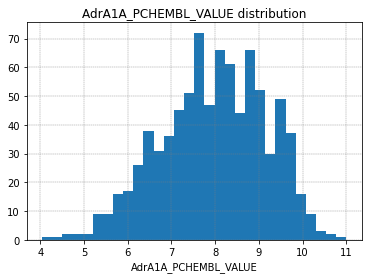

In [7]:
def build_histogram(input, title: str = ''):
    x = input
    n, bins, patches = plt.hist(x, 30)

    #plt.style.use('classic')
    plt.xlabel(title)
    plt.title(f'{title} distribution')
    plt.grid(True, color = "grey", linewidth = "0.4", linestyle = "dashed")
    plt.show()

build_histogram(input=dataset[ASSAY], title=ASSAY)

## Out-of-fold $r^2$ score estimations on train, validation and test datasets


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from utils.folds import oof

bundle = train_test_split(fingerprints, dataset, shuffle=True, random_state=SEED, test_size=0.25)

y_test = bundle[3]


### MLP

### Optuna

In [9]:
from functools import partial
from utils.mlp import Perceptron, PerceptronOptuna
import optuna

In [10]:
FINGER_TRIALS = 5


def fingerprints_optuna(trial, dataset):
    trial_dict = {
            "similarity_type": trial.suggest_categorical("similarity_type", ["ecfp4", "ecfp6", "ecfp8", "sim", "chem"]),
            "fp_sim_qwords": trial.suggest_int("fp_sim_qwords", 1, 32),
            "fp_ord_qwords": trial.suggest_int("fp_ord_qwords", 1, 32), #int = 25,
            "fp_any_qwords": trial.suggest_int("fp_any_qwords", 1, 32), #,int = 15,
            "fp_tau_qwords": trial.suggest_int("fp_tau_qwords", 1, 32), #int = 25,
            "fp_ext_enabled": trial.suggest_categorical("fp_ext_enabled", [0, 1]) #bool = True
        }
    fingerprints = get_fingerprints(dataset, **trial_dict)
    bundle = train_test_split(fingerprints, dataset, shuffle=True, random_state=SEED, test_size=0.25)
    ;
    y_test = bundle[3]


    model = Perceptron(input_size=len(fingerprints[0]), lr=0.00027, n_layers=1, batch_size=128, hidden_size=197, n_epochs=300, p_dropout=0.229)
    
    scores, y_pred = oof(model, bundle, assay=ASSAY)
    return np.mean(scores)

pruner = optuna.pruners.SuccessiveHalvingPruner()
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(direction='maximize', pruner=pruner, sampler=sampler)
part_opt = partial(fingerprints_optuna, dataset = dataset)
study.optimize(part_opt, n_trials=5)

[I 2022-02-07 11:57:45,681] A new study created in memory with name: no-name-e822fbfa-be17-4311-84d8-4ce303ab35ef
[I 2022-02-07 11:58:49,937] Trial 0 finished with value: 0.536843684123226 and parameters: {'similarity_type': 'ecfp8', 'fp_sim_qwords': 6, 'fp_ord_qwords': 25, 'fp_any_qwords': 13, 'fp_tau_qwords': 1, 'fp_ext_enabled': 1}. Best is trial 0 with value: 0.536843684123226.


MEAN TRAIN:  0.9173435258970606
MEAN VALIDATION:  0.4901966376749196
MEAN TEST 0.536843684123226


[I 2022-02-07 12:00:21,071] Trial 1 finished with value: 0.48424154658139484 and parameters: {'similarity_type': 'chem', 'fp_sim_qwords': 19, 'fp_ord_qwords': 23, 'fp_any_qwords': 25, 'fp_tau_qwords': 10, 'fp_ext_enabled': 0}. Best is trial 0 with value: 0.536843684123226.


MEAN TRAIN:  0.8980354110770733
MEAN VALIDATION:  0.451936860510702
MEAN TEST 0.48424154658139484


[I 2022-02-07 12:01:47,055] Trial 2 finished with value: 0.5706846237217006 and parameters: {'similarity_type': 'ecfp8', 'fp_sim_qwords': 22, 'fp_ord_qwords': 8, 'fp_any_qwords': 19, 'fp_tau_qwords': 26, 'fp_ext_enabled': 0}. Best is trial 2 with value: 0.5706846237217006.


MEAN TRAIN:  0.9565490652631693
MEAN VALIDATION:  0.4839870508914754
MEAN TEST 0.5706846237217006


[I 2022-02-07 12:03:25,078] Trial 3 finished with value: 0.4844227457768625 and parameters: {'similarity_type': 'chem', 'fp_sim_qwords': 5, 'fp_ord_qwords': 25, 'fp_any_qwords': 31, 'fp_tau_qwords': 27, 'fp_ext_enabled': 1}. Best is trial 2 with value: 0.5706846237217006.


MEAN TRAIN:  0.912619614592107
MEAN VALIDATION:  0.48096754672029884
MEAN TEST 0.4844227457768625


[I 2022-02-07 12:04:48,671] Trial 4 finished with value: 0.5294835586239726 and parameters: {'similarity_type': 'ecfp6', 'fp_sim_qwords': 13, 'fp_ord_qwords': 15, 'fp_any_qwords': 25, 'fp_tau_qwords': 17, 'fp_ext_enabled': 0}. Best is trial 2 with value: 0.5706846237217006.


MEAN TRAIN:  0.9423148670600163
MEAN VALIDATION:  0.4982377532685366
MEAN TEST 0.5294835586239726


In [18]:
best_fingers = study.best_params
print("best test score:", study.best_value)
print("best fingerprints: ", best_fingers)

best test score: 0.6067217561396026
best fingerprints:  {'similarity_type': 'ecfp6', 'fp_sim_qwords': 32, 'fp_ord_qwords': 4, 'fp_any_qwords': 10, 'fp_tau_qwords': 2, 'fp_ext_enabled': 0}


In [11]:
best_fingers = {'similarity_type': 'ecfp6', 'fp_sim_qwords': 32, 'fp_ord_qwords': 4, 'fp_any_qwords': 10, 'fp_tau_qwords': 2, 'fp_ext_enabled': 0}
MLP_TRIALS = 6

def mlp_optuna(trial, dataset, finger_params):
    fingerprints = get_fingerprints(dataset, **finger_params)

    bundle = train_test_split(fingerprints, dataset, shuffle=True, random_state=SEED, test_size=0.25)
    y_test = bundle[3]


    model = PerceptronOptuna(trial, input_size= len(fingerprints[0]), n_layers = 2, max_features = 100)
    
    scores, y_pred = oof(model, bundle, assay=ASSAY)
    return np.mean(scores)


pruner = optuna.pruners.SuccessiveHalvingPruner()
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(direction='maximize', pruner=pruner, sampler=sampler)
part_opt = partial(mlp_optuna, dataset = dataset, finger_params = best_fingers)
study.optimize(part_opt, n_trials=MLP_TRIALS, n_jobs = 3)

[I 2022-02-07 12:04:57,263] A new study created in memory with name: no-name-98f24857-6c47-4e04-8449-12181d22f203
c:\users\stepan_zhilin\pycharmprojects\ind\venv\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-02-07 12:05:28,375] Trial 2 finished with value: 0.49237971621542254 and parameters: {'n_layers': 1, 'n_units0': 19, 'dropout_l0': 0.38515828121123596, 'n_epochs': 252, 'batch_size': 256, 'lr': 0.00033092358928049127, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.49237971621542254.


MEAN TRAIN:  0.529850198867163
MEAN VALIDATION:  0.2949317661217935
MEAN TEST 0.49237971621542254


[I 2022-02-07 12:05:48,699] Trial 1 finished with value: 0.34663499655861074 and parameters: {'n_layers': 1, 'n_units0': 85, 'dropout_l0': 0.17126842625923985, 'n_epochs': 281, 'batch_size': 256, 'lr': 2.235553578726711e-05, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.49237971621542254.


MEAN TRAIN:  0.26807163319120664
MEAN VALIDATION:  0.21539803511080935
MEAN TEST 0.34663499655861074


[I 2022-02-07 12:07:03,072] Trial 4 finished with value: 0.6108797214836506 and parameters: {'n_layers': 2, 'n_units0': 74, 'dropout_l0': 0.2806167874429777, 'n_units1': 60, 'dropout_l1': 0.25087015045120514, 'n_epochs': 277, 'batch_size': 128, 'lr': 0.0003990838593502424, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.6108797214836506.


MEAN TRAIN:  0.932329560555007
MEAN VALIDATION:  0.5054899897762821
MEAN TEST 0.6108797214836506


[I 2022-02-07 12:07:16,475] Trial 3 finished with value: 0.4935522153401807 and parameters: {'n_layers': 1, 'n_units0': 20, 'dropout_l0': 0.2575217509579449, 'n_epochs': 481, 'batch_size': 64, 'lr': 3.061486362450562e-05, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.6108797214836506.


MEAN TRAIN:  0.4839636707993254
MEAN VALIDATION:  0.3317754965656088
MEAN TEST 0.4935522153401807


[I 2022-02-07 12:07:22,973] Trial 0 finished with value: 0.5926236581352636 and parameters: {'n_layers': 1, 'n_units0': 81, 'dropout_l0': 0.1047875213812677, 'n_epochs': 437, 'batch_size': 64, 'lr': 4.7527343324176144e-05, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.6108797214836506.


MEAN TRAIN:  0.818778398291719
MEAN VALIDATION:  0.48328610155466867
MEAN TEST 0.5926236581352636


[I 2022-02-07 12:07:50,992] Trial 5 finished with value: 0.38989951664060596 and parameters: {'n_layers': 1, 'n_units0': 73, 'dropout_l0': 0.035716712460703626, 'n_epochs': 343, 'batch_size': 128, 'lr': 1.596158986490942e-05, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.6108797214836506.


MEAN TRAIN:  0.3340586287061998
MEAN VALIDATION:  0.2605126584200721
MEAN TEST 0.38989951664060596


In [13]:
best_hype = study.best_params
print("best test score:", study.best_value)
print("best hype: ", best_hype)

best test score: 0.6223682520803688
best hype:  {'n_layers': 2, 'n_units0': 26, 'dropout_l0': 0.04287047595586951, 'n_units1': 68, 'dropout_l1': 0.4305921623134348, 'epochs': 493, 'batch_size': 256, 'lr': 0.000516399404187561, 'optimizer': 'Adam'}


C:\Users\Stepan_Zhilin\AppData\Local\Temp\ipykernel_3580\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

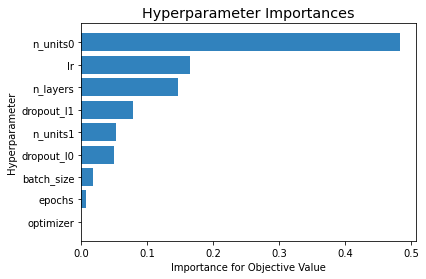

In [41]:
optuna.visualization.matplotlib.plot_param_importances(study)

In [19]:
fingerprints = get_fingerprints(dataset, **best_fingers)
# best_hype = {'n_layers': 2, 'n_units0': 26, 'dropout_l0': 0.04287047595586951, 'n_units1': 68, 'dropout_l1': 0.4305921623134348, 'n_epochs': 493, 'batch_size': 256, 'lr': 0.000516399404187561, 'optimizer': 'Adam'}
best_hype = {'n_layers': 2, 'n_units0': 74, 'dropout_l0': 0.2806167874429777, 'n_units1': 60, 'dropout_l1': 0.25087015045120514, 'n_epochs': 277, 'batch_size': 128, 'lr': 0.0003990838593502424, 'optimizer': 'Adam'}

bundle = train_test_split(fingerprints, dataset, shuffle=True, random_state=SEED, test_size=0.25)
y_test = bundle[3]


model = Perceptron(input_size=len(fingerprints[0]), **best_hype)
    
scores, y_pred = oof(model, bundle, assay=ASSAY)
np.mean(scores)

MEAN TRAIN:  0.9192137043598236
MEAN VALIDATION:  0.511132845711462
MEAN TEST 0.6040801038470438


0.6040801038470438